# Models comparison without features selection and with no hyperparameters optimization

## Imports

In [2]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from xgboost import XGBClassifier
import pandas as pd
import catboost as cb
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

## Load data

In [3]:
# Load genus relative abundance data as features
X = pd.read_csv("../genus_relative_abundance.csv", sep=";")
# Load species relative abundance data as features
# X = pd.read_csv("species_relative_abundance.csv", sep=";")
# Load labels 
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Class"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(212, 1128)


## Split the data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define models and KFold

In [104]:
# K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# models
models = {
  'Catboost': cb.CatBoostClassifier(thread_count=-1, verbose=False, random_state=42),
  'XGBoost': XGBClassifier(n_jobs=-1, random_state=42),
  'RF': RandomForestClassifier(warm_start=True, n_jobs=-1, random_state=42),
  'AdaBoost': AdaBoostClassifier(random_state=42),
  'LR': LogisticRegression(warm_start=True, n_jobs=-1, random_state=42),
  'SVM': SVC(random_state=42),
}

## Cross validate on metrics

In [117]:
# define metrics
metrics = ['accuracy', 'f1', 'roc_auc']
# dict for cv results 
cv_results = {}

for m_name, model in models.items():
  tmp_cv_scores = cross_validate(estimator=model, X=X, y=y, scoring=metrics, cv=skf)
  # cv_results[m_name] = [tmp_cv_scores.get(f'test_{k}') for k in metrics]
  cv_results[m_name] = tmp_cv_scores

## Plot the results

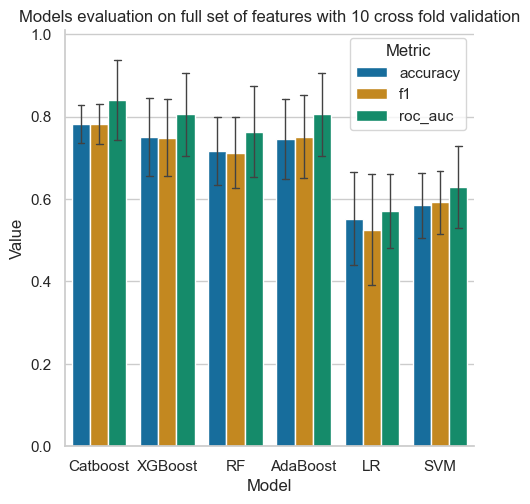

In [118]:
# Create an empty list to hold the data
plot_data = []

# Iterate over the dictionary
for model, values in cv_results.items():
    for key, arr in values.items():
        if key.startswith("test_"):
            for value in arr:
                plot_data.append({"Model": model, "Metric": key[5:], "Value": value})

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(plot_data)

# # Create the plot using Seaborn
sns.set(style="whitegrid")
g = sns.catplot(data=df,
            x="Model",
            y="Value",
            hue="Metric",
            kind="bar",
            estimator=np.mean,
            errorbar='sd',
            capsize=0.1,
            errwidth=1,
            # col_wrap=3,
            legend=True,
            sharex=False,
            sharey=False,
            legend_out=False,
            palette='colorblind'
)
g.set(ylim=(0, 1.01))
# Add labels and title to the plot
plt.xlabel("Model")
plt.ylabel("Value")
plt.title("Models evaluation on full set of features with 10 cross fold validation")

# Rotate x-axis labels if needed
# plt.xticks(rotation=45)

# Show the plot
plt.show()